In [38]:
from numpy.random import multinomial
from numpy import log, exp
from sklearn.metrics.cluster import normalized_mutual_info_score, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
import json
import matplotlib.pyplot as plt
import numpy as np

class GibbsSamplingDMM:
    def __init__(self, K=300, D=1000, alpha=0.1, beta=0.1, n_iters=10):
        self.K = K
        self.D = D
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]
        self.document_word_distribution = [{} for i in range(D)]
        self.iterations_document_cluster_distribution = [[] for i in range(n_iters)]

    @staticmethod
    def _sample(p):
  
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):

        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        m_z, n_z, n_z_w, n_d_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution, self.document_word_distribution
        cluster_count = K
        i_d_z = self.iterations_document_cluster_distribution
        d_z = [None for i in range(len(docs))]

        # initialize the clusters
        for i, doc in enumerate(docs):

            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])
            d_z[i] = z
            m_z[z] += 1
            n_z[z] += len(doc) 

            for word in doc:
                if word not in n_d_w[i]:
                    n_d_w[i][word] = 0
                n_d_w[i][word] += 1

            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0
                n_z_w[z][word] += 1

        for _iter in range(n_iters):
            total_transfers = 0

            for i, doc in enumerate(docs):

                # remove the doc from it's current cluster
                z_old = d_z[i]

                m_z[z_old] -= 1
                n_z[z_old] -= len(doc)

                for word in doc:
                    n_z_w[z_old][word] -= 1

                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc, i)
                z_new = self._sample(p)

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1

                d_z[i] = z_new
                i_d_z[_iter].append(d_z[i])
                m_z[z_new] += 1
                n_z[z_new] += len(doc)

                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            
            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In iteration %d: transferred %d clusters with %d clusters populated" % (
            _iter + 1, total_transfers, cluster_count_new))
            if total_transfers == 0 and cluster_count_new == cluster_count and _iter>5:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new

        self.cluster_word_distribution = n_z_w
        return d_z

    def score(self, doc, index):
    
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w, n_d_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution, self.document_word_distribution

        p = [0 for _ in range(K)]

        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lD1 = log(D - 1 + K*alpha)
        #  lN2 = log(product(product(n_z_w[w] + beta + j - 1))) 
        #      = sum(log(product(n_z_w[w] + beta + j - 1)))
        #      = sum(sum(log(n_z_w[w] + beta + j  - 1)))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) 
        #      = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):
            lN1 = log(m_z[label] + alpha)
            lN2 = 0
            lD2 = 0
            for word in doc:
                temp = 0
                for j in range(n_d_w[index][word]):
                    temp += log(n_z_w[label].get(word, 0) + beta + j)
                lN2 += temp
            for i in range(1, doc_size +1):
                lD2 += log(n_z[label] + V * beta + i - 1)
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm>0 else 1
        return [pp/pnorm for pp in p]
    
    def results(self, labels_true, labels_pred):

        NMI = normalized_mutual_info_score(labels_true, labels_pred)
        H = homogeneity_score(labels_true, labels_pred)
        C = completeness_score(labels_true, labels_pred)
        ARI = adjusted_rand_score(labels_true, labels_pred)
        AMI = adjusted_mutual_info_score(labels_true, labels_pred)
        print('Normalized Mutual Information = ', round(NMI,5))
        print('Homogeneity = ', round(H,5))
        print('Completeness = ', round(C,5))
        print('Adjusted Rand Index = ', round(ARI,5))
        print('Adjusted Mutual Information = ', round(AMI,5))

    def plots(self, labels_true, filename):
        NMI = []
        H = []
        C = []
        ARI = []
        AMI = []
        i_d_z = self.iterations_document_cluster_distribution
        n_iters = self.n_iters
        for i in range(n_iters):
            labels_pred = i_d_z[i]
            NMI.append(normalized_mutual_info_score(labels_true, labels_pred))
            H.append(homogeneity_score(labels_true, labels_pred))
            C.append(completeness_score(labels_true, labels_pred))
            ARI.append(adjusted_rand_score(labels_true, labels_pred))
            AMI.append(adjusted_mutual_info_score(labels_true, labels_pred))
        
        _iter = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10]
        f = plt.figure() 
        f.set_figwidth(10) 
        f.set_figheight(6) 
        plt.plot(_iter, NMI, color='g', label='Normalized Mutual Information')
        plt.plot(_iter, H, color='b', label='Homogeneity')
        plt.plot(_iter, C, color='r', label='Completeness')
        plt.plot(_iter, ARI, color='y', label='Adjusted Rand Index')
        plt.plot(_iter, AMI, color='c', label='Adjusted Mutual Information')
        plt.title(filename)
        plt.xlabel('Iterations')
        plt.ylabel('Performance')
        plt.legend()
        plt.show()

In [21]:
def test(filename):

    data = [json.loads(line) for line in open(filename, 'r')]

    docs = []
    labels_true = []

    num = 0
    vocab = set()

    for element in data:
        num += 1
        labels_true.append(element['cluster'])
        docs.append(list(element['text'].split()))
        vocab = vocab.union(set(list(element['text'].split())))

    vocab_size = len(vocab)
        

    gsdmm = GibbsSamplingDMM(K=300,D=len(docs), n_iters=10, alpha=0.1, beta=0.1)
    labels_pred = gsdmm.fit(docs, vocab_size)
    gsdmm.results(labels_true, labels_pred)
    gsdmm.plots(labels_true, filename)

In iteration 0: transferred 2278 clusters with 235 clusters populated
In iteration 1: transferred 851 clusters with 136 clusters populated
In iteration 2: transferred 394 clusters with 114 clusters populated
In iteration 3: transferred 266 clusters with 103 clusters populated
In iteration 4: transferred 224 clusters with 100 clusters populated
In iteration 5: transferred 181 clusters with 97 clusters populated
In iteration 6: transferred 173 clusters with 95 clusters populated
In iteration 7: transferred 169 clusters with 91 clusters populated
In iteration 8: transferred 164 clusters with 90 clusters populated
In iteration 9: transferred 158 clusters with 90 clusters populated
Normalized Mutual Information =  0.86507
Homogeneity =  0.86737
Completeness =  0.86277
Adjusted Rand Index =  0.77777
Adjusted Mutual Information =  0.83298


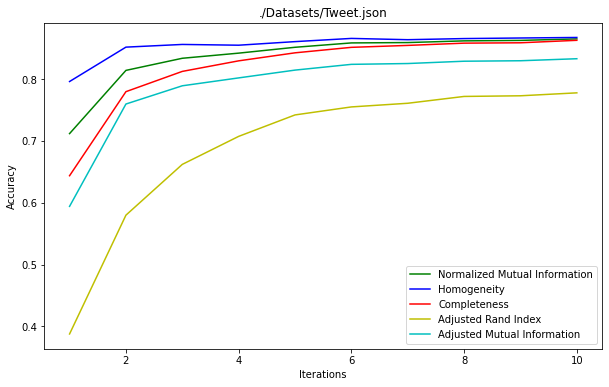

In [22]:
test('./Datasets/Tweet.json')

In iteration 0: transferred 10536 clusters with 299 clusters populated
In iteration 1: transferred 4351 clusters with 233 clusters populated
In iteration 2: transferred 1690 clusters with 177 clusters populated
In iteration 3: transferred 1018 clusters with 155 clusters populated
In iteration 4: transferred 831 clusters with 147 clusters populated
In iteration 5: transferred 759 clusters with 142 clusters populated
In iteration 6: transferred 689 clusters with 136 clusters populated
In iteration 7: transferred 689 clusters with 133 clusters populated
In iteration 8: transferred 691 clusters with 131 clusters populated
In iteration 9: transferred 645 clusters with 129 clusters populated
Normalized Mutual Information =  0.87753
Homogeneity =  0.86282
Completeness =  0.89276
Adjusted Rand Index =  0.72597
Adjusted Mutual Information =  0.85865


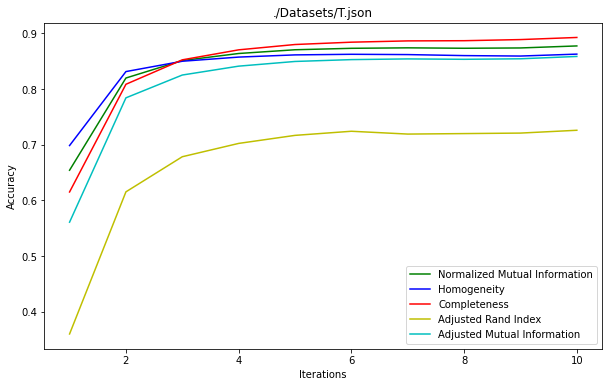

In [23]:
test('./Datasets/T.json')

In iteration 0: transferred 10596 clusters with 295 clusters populated
In iteration 1: transferred 2303 clusters with 169 clusters populated
In iteration 2: transferred 529 clusters with 148 clusters populated
In iteration 3: transferred 283 clusters with 140 clusters populated
In iteration 4: transferred 197 clusters with 139 clusters populated
In iteration 5: transferred 186 clusters with 137 clusters populated
In iteration 6: transferred 158 clusters with 137 clusters populated
In iteration 7: transferred 141 clusters with 135 clusters populated
In iteration 8: transferred 139 clusters with 134 clusters populated
In iteration 9: transferred 132 clusters with 132 clusters populated
Normalized Mutual Information =  0.88414
Homogeneity =  0.85084
Completeness =  0.92016
Adjusted Rand Index =  0.70019
Adjusted Mutual Information =  0.86768


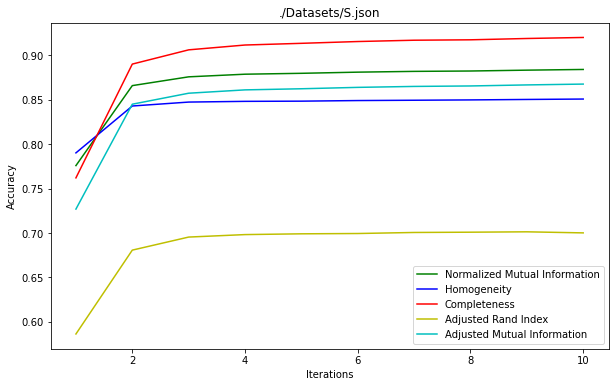

In [24]:
test('./Datasets/S.json')

In iteration 0: transferred 10692 clusters with 273 clusters populated
In iteration 1: transferred 1273 clusters with 157 clusters populated
In iteration 2: transferred 243 clusters with 143 clusters populated
In iteration 3: transferred 113 clusters with 139 clusters populated
In iteration 4: transferred 66 clusters with 137 clusters populated
In iteration 5: transferred 53 clusters with 137 clusters populated
In iteration 6: transferred 45 clusters with 136 clusters populated
In iteration 7: transferred 55 clusters with 136 clusters populated
In iteration 8: transferred 42 clusters with 136 clusters populated
In iteration 9: transferred 50 clusters with 136 clusters populated
Normalized Mutual Information =  0.93234
Homogeneity =  0.90535
Completeness =  0.96099
Adjusted Rand Index =  0.80278
Adjusted Mutual Information =  0.92226


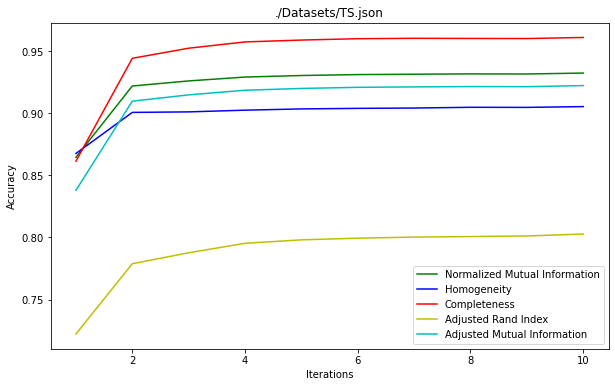

In [25]:
test('./Datasets/TS.json')

For K =  100
In iteration 0: transferred 2244 clusters with 99 clusters populated
In iteration 1: transferred 790 clusters with 87 clusters populated
In iteration 2: transferred 367 clusters with 81 clusters populated
In iteration 3: transferred 253 clusters with 77 clusters populated
In iteration 4: transferred 205 clusters with 76 clusters populated
In iteration 5: transferred 169 clusters with 76 clusters populated
In iteration 6: transferred 158 clusters with 73 clusters populated
In iteration 7: transferred 121 clusters with 73 clusters populated
In iteration 8: transferred 128 clusters with 74 clusters populated
In iteration 9: transferred 149 clusters with 72 clusters populated
For K =  200
In iteration 0: transferred 2262 clusters with 174 clusters populated
In iteration 1: transferred 785 clusters with 108 clusters populated
In iteration 2: transferred 319 clusters with 91 clusters populated
In iteration 3: transferred 227 clusters with 90 clusters populated
In iteration 4: tr

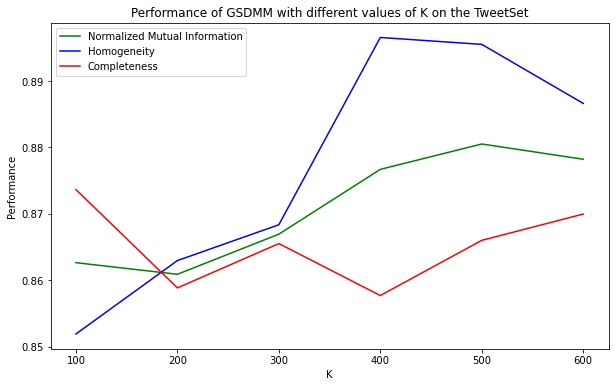

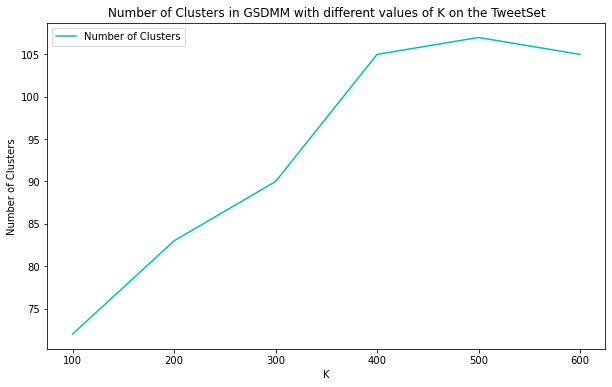

In [34]:
data = [json.loads(line) for line in open('./Datasets/Tweet.json', 'r')]

docs = []
labels_true = []

num = 0
vocab = set()

for element in data:
    num += 1
    labels_true.append(element['cluster'])
    docs.append(list(element['text'].split()))
    vocab = vocab.union(set(list(element['text'].split())))

vocab_size = len(vocab)

NMI_k = []
H_k = []
C_k = []
Number_of_clusters = []


for k in range(100, 700, 100):
    print('For K = ', k)
    gsdmm = GibbsSamplingDMM(K=k, D=num, n_iters=10, alpha=0.1, beta=0.1)
    labels_pred = gsdmm.fit(docs, vocab_size)
    NMI_k.append(normalized_mutual_info_score(labels_true, labels_pred))
    H_k.append(homogeneity_score(labels_true, labels_pred))
    C_k.append(completeness_score(labels_true, labels_pred))
    Number_of_clusters.append(len(set(list(labels_pred))))

x = [100, 200, 300, 400, 500, 600]

f = plt.figure() 
f.set_figwidth(10) 
f.set_figheight(6)
plt.plot(x, NMI_k, 'g', label='Normalized Mutual Information')
plt.plot(x, H_k, 'b', label='Homogeneity')
plt.plot(x, C_k, 'r', label='Completeness')
plt.title('Performance of GSDMM with different values of K on the TweetSet')
plt.xlabel('K')
plt.ylabel('Performance')
plt.legend()
plt.show()

f1 = plt.figure() 
f1.set_figwidth(10) 
f1.set_figheight(6)
plt.plot(x, Number_of_clusters, 'c', label='Number of Clusters')
plt.title('Number of Clusters in GSDMM with different values of K on the TweetSet')
plt.xlabel('K')
plt.ylabel('Number of Clusters')
plt.legend()
plt.show()

For Alpha =  0.1
In iteration 0: transferred 2276 clusters with 231 clusters populated
In iteration 1: transferred 766 clusters with 138 clusters populated
In iteration 2: transferred 318 clusters with 110 clusters populated
In iteration 3: transferred 225 clusters with 103 clusters populated
In iteration 4: transferred 202 clusters with 103 clusters populated
In iteration 5: transferred 181 clusters with 102 clusters populated
In iteration 6: transferred 174 clusters with 101 clusters populated
In iteration 7: transferred 165 clusters with 99 clusters populated
In iteration 8: transferred 155 clusters with 98 clusters populated
In iteration 9: transferred 158 clusters with 101 clusters populated
For Alpha =  0.2
In iteration 0: transferred 2271 clusters with 232 clusters populated
In iteration 1: transferred 806 clusters with 132 clusters populated
In iteration 2: transferred 327 clusters with 114 clusters populated
In iteration 3: transferred 251 clusters with 100 clusters populated


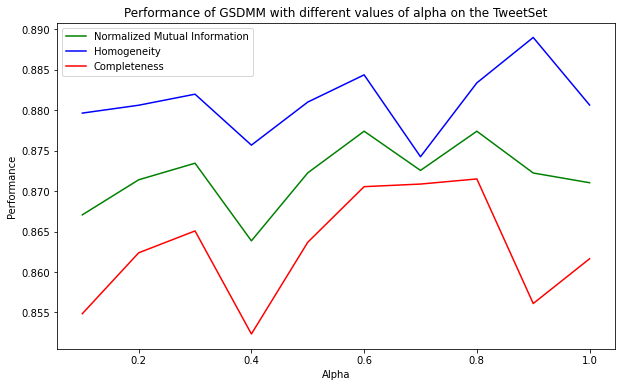

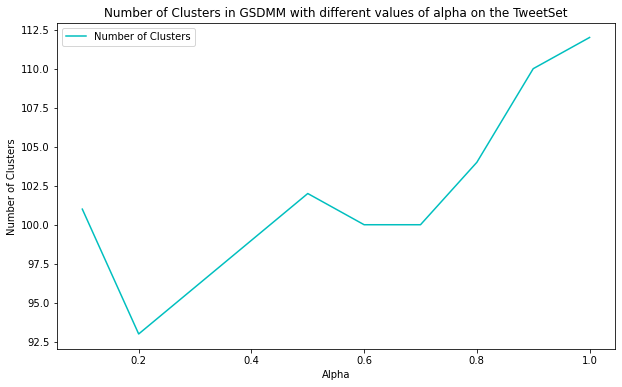

In [36]:
data = [json.loads(line) for line in open('./Datasets/Tweet.json', 'r')]

docs = []
labels_true = []

num = 0
vocab = set()

for element in data:
    num += 1
    labels_true.append(element['cluster'])
    docs.append(list(element['text'].split()))
    vocab = vocab.union(set(list(element['text'].split())))

vocab_size = len(vocab)

NMI_k = []
H_k = []
C_k = []
Number_of_clusters = []

_alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in _alpha:
    print('For Alpha = ', i)
    gsdmm = GibbsSamplingDMM(K=300, D=num, n_iters=10, alpha = i, beta=0.1)
    labels_pred = gsdmm.fit(docs, vocab_size)
    NMI_k.append(normalized_mutual_info_score(labels_true, labels_pred))
    H_k.append(homogeneity_score(labels_true, labels_pred))
    C_k.append(completeness_score(labels_true, labels_pred))
    Number_of_clusters.append(len(set(list(labels_pred))))

f = plt.figure() 
f.set_figwidth(10) 
f.set_figheight(6) 
plt.plot(_alpha, NMI_k, 'g', label='Normalized Mutual Information')
plt.plot(_alpha, H_k, 'b', label='Homogeneity')
plt.plot(_alpha, C_k, 'r', label='Completeness')
plt.title('Performance of GSDMM with different values of alpha on the TweetSet')
plt.xlabel('Alpha')
plt.ylabel('Performance')
plt.legend()
plt.show()

f1 = plt.figure() 
f1.set_figwidth(10) 
f1.set_figheight(6) 
plt.plot(_alpha, Number_of_clusters, 'c', label='Number of Clusters')
plt.title('Number of Clusters in GSDMM with different values of alpha on the TweetSet')
plt.xlabel('Alpha')
plt.ylabel('Number of Clusters')
plt.legend()
plt.show()

For Beta =  0.02
In iteration 0: transferred 2176 clusters with 261 clusters populated
In iteration 1: transferred 808 clusters with 206 clusters populated
In iteration 2: transferred 401 clusters with 192 clusters populated
In iteration 3: transferred 315 clusters with 183 clusters populated
In iteration 4: transferred 271 clusters with 177 clusters populated
In iteration 5: transferred 233 clusters with 177 clusters populated
In iteration 6: transferred 237 clusters with 174 clusters populated
In iteration 7: transferred 220 clusters with 169 clusters populated
In iteration 8: transferred 220 clusters with 167 clusters populated
In iteration 9: transferred 233 clusters with 166 clusters populated
For Beta =  0.04
In iteration 0: transferred 2217 clusters with 260 clusters populated
In iteration 1: transferred 824 clusters with 184 clusters populated
In iteration 2: transferred 377 clusters with 161 clusters populated
In iteration 3: transferred 291 clusters with 149 clusters populate

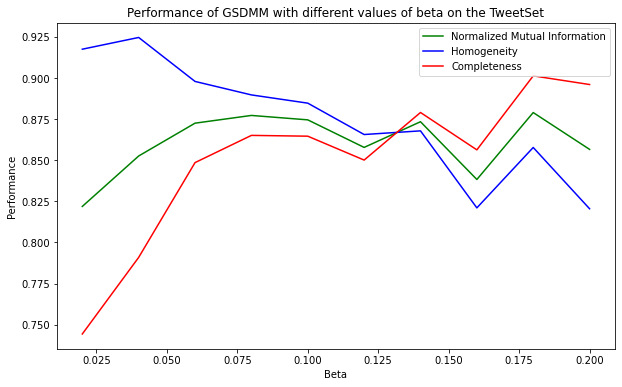

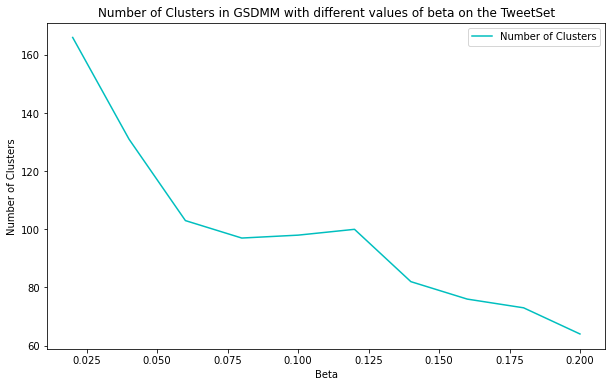

In [37]:
data = [json.loads(line) for line in open('./Datasets/Tweet.json', 'r')]

docs = []
labels_true = []

num = 0
vocab = set()

for element in data:
    num += 1
    labels_true.append(element['cluster'])
    docs.append(list(element['text'].split()))
    vocab = vocab.union(set(list(element['text'].split())))

vocab_size = len(vocab)

NMI_k = []
H_k = []
C_k = []
Number_of_clusters = []


_beta = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.20]

for i in _beta:
    print('For Beta = ', i)
    gsdmm = GibbsSamplingDMM(K=300, D=num, n_iters=10, alpha=0.1, beta=i)
    labels_pred = gsdmm.fit(docs, vocab_size)
    NMI_k.append(normalized_mutual_info_score(labels_true, labels_pred))
    H_k.append(homogeneity_score(labels_true, labels_pred))
    C_k.append(completeness_score(labels_true, labels_pred))
    Number_of_clusters.append(len(set(list(labels_pred))))

f = plt.figure() 
f.set_figwidth(10) 
f.set_figheight(6) 
plt.plot(_beta, NMI_k, 'g', label='Normalized Mutual Information')
plt.plot(_beta, H_k, 'b', label='Homogeneity')
plt.plot(_beta, C_k, 'r', label='Completeness')
plt.title('Performance of GSDMM with different values of beta on the TweetSet')
plt.xlabel('Beta')
plt.ylabel('Performance')
plt.legend()
plt.show()

f1 = plt.figure() 
f1.set_figwidth(10) 
f1.set_figheight(6) 
plt.plot(_beta, Number_of_clusters, 'c', label='Number of Clusters')
plt.title('Number of Clusters in GSDMM with different values of beta on the TweetSet')
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.legend()
plt.show()

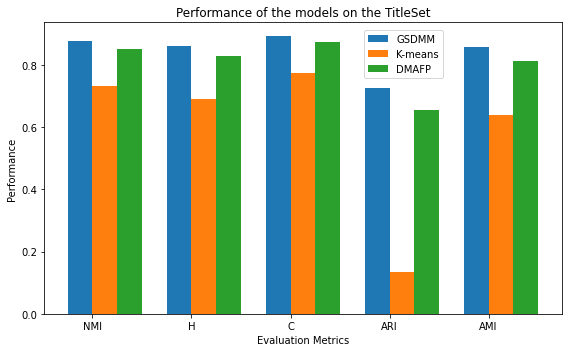

In [93]:
labels = ['NMI', 'H', 'C', 'ARI', 'AMI']
GSDMM = [0.878, 0.863, 0.893, 0.726, 0.859]
K_means = [0.732, 0.692, 0.775, 0.133, 0.639]
DMAFP = [0.852, 0.831, 0.875, 0.657, 0.814]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
fig.set_figwidth(8) 
fig.set_figheight(5) 
plt.autoscale(enable=True, axis='both', tight=None)
rects1 = ax.bar(x - width/2, GSDMM, width, label='GSDMM')
rects2 = ax.bar(x + width/2, K_means, width, label='K-means')
rects3 = ax.bar(x + (3 * width)/2, DMAFP, width, label='DMAFP')


ax.set_ylabel('Performance')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Performance of the models on the TitleSet')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right", bbox_to_anchor=(0.78,0.99))

fig.tight_layout()

plt.show()

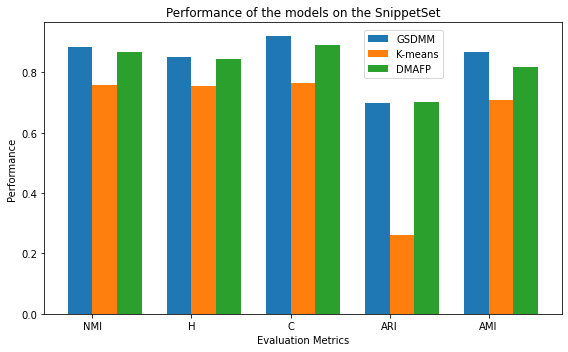

In [94]:
labels = ['NMI', 'H', 'C', 'ARI', 'AMI']
GSDMM = [0.884, 0.851, 0.920, 0.700, 0.868]
K_means = [0.759, 0.754, 0.764, 0.262, 0.708]
DMAFP = [0.868, 0.846, 0.892, 0.703, 0.819]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
fig.set_figwidth(8) 
fig.set_figheight(5) 
rects1 = ax.bar(x - width/2, GSDMM, width, label='GSDMM')
rects2 = ax.bar(x + width/2, K_means, width, label='K-means')
rects3 = ax.bar(x + (3 * width)/2, DMAFP, width, label='DMAFP')


ax.set_ylabel('Performance')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Performance of the models on the SnippetSet')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right", bbox_to_anchor=(0.78,0.99))

fig.tight_layout()

plt.show()

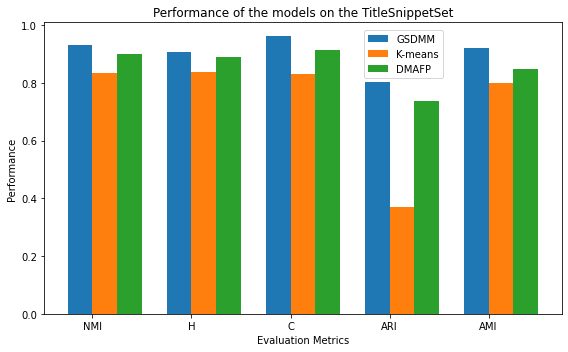

In [95]:
labels = ['NMI', 'H', 'C', 'ARI', 'AMI']
GSDMM = [0.932, 0.905, 0.961, 0.803, 0.922]
K_means = [0.834, 0.836, 0.832, 0.370, 0.800]
DMAFP = [0.901, 0.889, 0.912, 0.736, 0.847]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
fig.set_figwidth(8) 
fig.set_figheight(5) 
rects1 = ax.bar(x - width/2, GSDMM, width, label='GSDMM')
rects2 = ax.bar(x + width/2, K_means, width, label='K-means')
rects3 = ax.bar(x + (3 * width)/2, DMAFP, width, label='DMAFP')


ax.set_ylabel('Performance')
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Performance of the models on the TitleSnippetSet')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right", bbox_to_anchor=(0.78,0.99))

fig.tight_layout()

plt.show()